In [1]:
def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')

In [2]:
if is_interactive():
    get_ipython().magic('%matplotlib notebook')
    from matplotlib.pyplot import *
    rcParams['figure.dpi'] = 100

In [3]:
import sys
import os.path
sys.path.append(os.path.abspath('..'))

In [4]:
from trainingwheel.core import *

In [5]:
import math
import torch
from torch.distributions.constraint_registry import ConstraintRegistry
from torch.distributions import constraints, biject_to
#from .parameters import ProjectedExactGPHypers, ProjectedExactGP1DHypers
import attr

from torch.utils.data import TensorDataset, DataLoader

import sys
sys.path.append('/home/aloukian/Documents/unholy')
sys.path.append('/home/aloukian/Documents/efficiency-comparison/')
from lib.datagen import LengthscaleDatagenRecipe, make_lengthscale_data
from lib.parameters import ProjectedExactGP1DHypers

from torchgp.symbolic import *
from torchgp.transforms import *
from torchgp.means import *
from torchgp.kernels import *
from torchgp.functional import numpyify
from torchgp.parameterizations.basic import VarGP1DGauss, VarGP1DGaussHypers
torch.set_default_dtype(torch.float64)
from collections import namedtuple, OrderedDict

In [6]:
import math

@attr.s(auto_attribs=True)
class ExpUpdater(StatefulCallback):
    parameter_name: str = 'param'
    gamma: float = 1.0
    min_size: int = 256
    max_size: int = 65536
    
    def process(self, phase, loop):
        """
        Update the batchsize
        """
        state_path = "".join([phase.name, '.', self.parameter_name])
        update = self.min_size*math.exp((self.event_counter)*math.log(self.gamma))
        size = int(min(self.max_size, update))
        loop.state[state_path] = size
        return size

In [7]:
import tqdm

@attr.s(auto_attribs=True)
class EpochProgressBar(Callback):
    progress_bar: Optional[tqdm.tqdm] = None
    
    def create(self, loop):
        epoch = loop.state['epoch']
        max_epochs = loop.state['max_epochs']
        self.progress_bar = tqdm.tqdm(initial=epoch, total=max_epochs, unit='ep', desc="Processing epochs")
    
    def process(self, loop, epoch, max_epochs):
        self.progress_bar.last_print_n = epoch - 1
        self.progress_bar.update()
    
    def reset(self, loop):
        super().reset(loop)
        
        if self.progress_bar is not None:
            self.progress_bar.close()        

In [8]:
def setup_logging():
    log = logging.getLogger(__name__)
    handler = logging.StreamHandler(stream=sys.stdout)
    handler.setFormatter(
        logging.Formatter(
            "%(asctime)-15s %(levelname)-6s %(message)s"
        )
    )
    log.addHandler(handler)
    log.setLevel(logging.INFO)

    return log

log = setup_logging()

In [9]:
log.setLevel(logging.DEBUG)

In [10]:
def _convert_to_python(tensor):
    if isinstance(tensor, (int, float, str)):
        return tensor
    else:
        return tensor.detach().cpu()

@attr.s(auto_attribs=True)
class MetricLogger(Callback):
    metric_log: State = attr.ib(factory=State)
    
    def process(self, phase, loop):
        log.debug(f'triggered MetricLogger on phase {phase.name}')
        model = loop.model
        
        with torch.no_grad():
            # extract current metrics for the model
            metrics = model.metrics
            sigma2 = _convert_to_python(metrics['sigma2'])
            Kr_lengthscale = _convert_to_python(metrics['Kr_lengthscale'])
            Kr_amplitude = _convert_to_python(metrics['Kr_amplitude'])
            v = _convert_to_python(metrics['v'])
            m = _convert_to_python(metrics['m'])

            # store gradient norms also
            sigma2_norm = torch.norm(model.stored_params["sigma2"]).item()
            
            if model.stored_params["sigma2"].grad is not None:
                sigma2_gradnorm = torch.norm(model.stored_params["sigma2"].grad).item()
            else:
                sigma2_gradnorm = None

            Kr_lengthscale_norm = torch.norm(model.stored_K["Kr"]._lengthscale_storage).item()
            
            if model.stored_K["Kr"]._lengthscale_storage.grad is not None:
                Kr_lengthscale_gradnorm = torch.norm(model.stored_K["Kr"]._lengthscale_storage.grad).item()
            else:
                Kr_lengthscale_gradnorm = None
                
            Kr_amplitude_norm = torch.norm(model.stored_K["Kr"]._amplitude_storage).item()
            if model.stored_K["Kr"]._amplitude_storage.grad is not None:
                Kr_amplitude_gradnorm = torch.norm(model.stored_K["Kr"]._amplitude_storage.grad).item()
            else:
                Kr_amplitude_gradnorm = None
                
            v_norm = torch.norm(model.stored_params["v"]).item()
            if model.stored_params["v"].grad is not None:
                v_gradnorm = torch.norm(model.stored_params["v"].grad).item()
            else:
                v_gradnorm = None
                
            m_norm = torch.norm(model.stored_params["m"]).item()
            
            if model.stored_params["m"].grad is not None:
                m_gradnorm = torch.norm(model.stored_params["m"].grad).item()
            else:
                m_gradnorm = None
        
        # also record batch size and kl_scale
        batch_size = loop.state.get(phase.name + '.batch_size', None)
        kl_scale = loop.state.get(phase.name + '.kl_scale', None)
        
        updates = {
            'sigma2': sigma2,
            'sigma2_norm': sigma2_norm,
            'Kr_lengthscale': Kr_lengthscale,
            'Kr_lengthscale_norm': Kr_lengthscale_norm,
            'Kr_lengthscale_gradnorm': Kr_lengthscale_gradnorm,
            'Kr_amplitude': Kr_amplitude,
            'Kr_amplitude_norm': Kr_amplitude_norm,
            'Kr_amplitude_gradnorm': Kr_amplitude_gradnorm,
            'm': m,
            'm_norm': m_norm,
            'm_gradnorm': m_gradnorm,
            'v': v,
            'v_norm': v_norm,
            'v_gradnorm': v_gradnorm,
            'batch_size': batch_size,
            'kl_scale': kl_scale,
        }
        
        epoch = loop.state['epoch']
        
        for metric_name, metric in updates.items():
            metric_path = ''.join([phase.name, '.', 'metrics', '.', metric_name])
            _log = self.metric_log.setdefault(metric_path, [])
            _log.append((epoch, metric))

In [11]:
recipe= LengthscaleDatagenRecipe(
            gibbs_fun_parameters=(0.0, 0., 0., 0.05),
            noise_model='gaussian',
            noise_snr=1.,
            sizes=(100000, 150),
            scan_strategy='pink',
            sase_spikes_per_bin=1.0,
            sase_bw=1.5,
            random_seed=151195,
            experiment_name='Test QR V1',
            project_name=None,
        )

axfr, k1, F, W, Y = make_lengthscale_data(recipe)

Mean of pink signal: 162.23577747270886


In [12]:
train_split_size = int(0.90*W.shape[0])
Wtrain, Ytrain = W[:train_split_size], Y[:train_split_size]
Wvalidate, Yvalidate = W[train_split_size:], Y[train_split_size:]

In [13]:
biject_to(constraints.interval(-1.1, 1.1))

ComposeTransform(
    SigmoidTransform(),
    AffineTransform()
)

In [41]:
hypers = VarGP1DGaussHypers()
#metrics = exact_model.metrics
hypers.sigma2 = 1.0
#hypers.Kr_amplitude = metrics['Kr_amplitude']
hypers.Kr_lengthscale = 0.05
hypers.Kr_inducing_count = 60
hypers.Kr_jitter = 1e-6
print(hypers)

var_model = VarGP1DGauss.from_buffers(axfr, hypers=attr.asdict(hypers))
var_model.stored_params['axur'].requires_grad_(False)

#var_model.match_posterior(mhat=F, Lvhat=None)


train_data = TensorDataset(Wtrain, Ytrain)
validate_data = [[Wvalidate, Yvalidate]]
full_datasize = W.shape[0]
optimizer = torch.optim.Adam(var_model.parameters(), lr=1e-2)

VarGP1DGaussHypers(kernel_type='ARDRBF', constraint_registry=None, Kr_lengthscale=0.05, Kr_amplitude=1.0, Kr_jitter=1e-06, Kr_inducing_count=60, sigma2=1.0)
Module path:  /home/aloukian/Documents/trainingwheel/notebook/.compiled/9e105210a5b09098.py
Module path:  /home/aloukian/Documents/trainingwheel/notebook/.compiled/db6ab08ea7c955bd.py
Module path:  /home/aloukian/Documents/trainingwheel/notebook/.compiled/3ab82278a3a61275.py
Module path:  /home/aloukian/Documents/trainingwheel/notebook/.compiled/74cc732d995245af.py
Module path:  /home/aloukian/Documents/trainingwheel/notebook/.compiled/9ba4ae19090c2e31.py
Using kernel type ARDRBF
Using default constraint registry


In [42]:
m, v = var_model.predict(axfr)

<IPython.core.display.Javascript object>


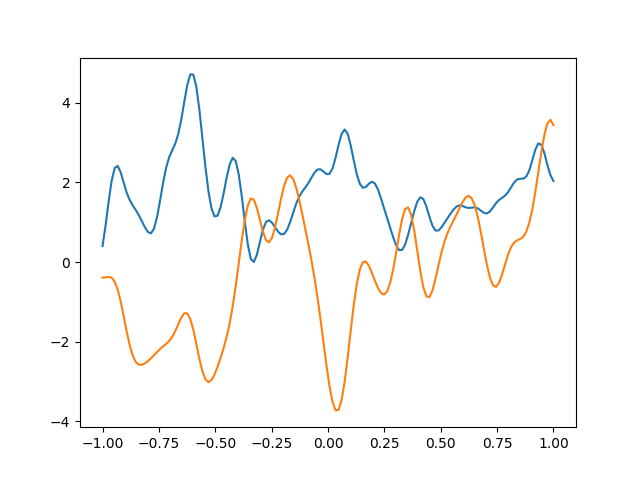

In [43]:
figure()
plot(numpyify(axfr), numpyify(F))
plot(numpyify(axfr), numpyify(m))

<IPython.core.display.Javascript object>


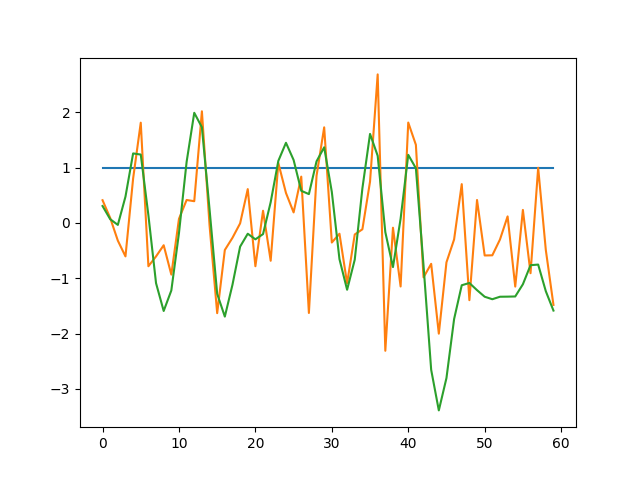

In [18]:
figure()
plot(numpyify(var_model.metrics['v']))

In [44]:
#model(tra)
var_model.expect_loss(*train_data[:10000], M=full_datasize, kl_scale=1.0)

tensor(2.0019e+09)

In [47]:
# Create minibatch trainer for models
def prepare_and_place_data(batch, device=None):
    """
    Prepares a minibatch for consumption by the GP model.
    
    Args:
        batch: a tuple of Tensors
    """
    Wbatch, Ybatch = map(lambda x: x.to(device), batch)
    
    return Wbatch, Ybatch

def update_training(data, loop, phase):
    optimizer = loop.optimizers["train"]
    
       
    Wbatch, Ybatch = prepare_and_place_data(data, loop.device)
    #log.debug("training batch size {}".format(Wbatch.shape[0]))
    kl_scale = loop.state['train.kl_scale']
    loss = loop.loss_fn(Wbatch, Ybatch, M=full_datasize, kl_scale=kl_scale)
    loss.backward()
    #log.info(f"Training loss: {loss.item()}")
    model = loop.model
    l2_loss = model.expect_metrics(Wbatch, Ybatch, M=full_datasize)
    optimizer.step()
    return loss.item(), l2_loss.item()
    
def update_validation(data, loop, phase):
    Wbatch, Ybatch = prepare_and_place_data(data, loop.device)
    
    kl_scale = loop.state['train.kl_scale']
    loss = loop.loss_fn(Wbatch, Ybatch, M=full_datasize, kl_scale=kl_scale)
    #log.info(f"Validation loss: {loss.item()}")
    model = loop.model
    l2_loss = model.expect_metrics(Wbatch, Ybatch, M=full_datasize)
    return loss.item(), l2_loss.item()
    
loop = Loop(model=var_model,
            loss_fn=var_model.kl_loss,
            optimizers={"train": optimizer},
            phases={
                "train": Phase("train", None, update_state=update_training, with_gradient=True),
                "validate": Phase("validate", validate_data, update_state=update_validation, with_gradient=False),
            },
            callbacks={
                "metric_logger": MetricLogger(),
                "train.batch_size": ExpUpdater(parameter_name='batch_size', min_size=2000, gamma=1.),
            },
            device="cuda")

In [48]:
# disconnect all signals
disconnect_all()

# move model to device
@connect_via("loop_started", loop)
def place_model(loop: Loop):
    """
    Move model to device specified in loop
    """
    log.debug(f'place model triggered')
    loop.model.to(loop.device)

@connect_via("loop_started", loop)
def initialize_state(loop):
    loop.state["train.kl_scale"] = 1.0
    loop.state["validate.kl_scale"] = 1.0

# add progress bar
#connect("loop_started", loop.callbacks["epoch_pg"].create, loop)
#connect("epoch_completed", loop.callbacks["epoch_pg"].process, loop)
#connect("loop_completed", loop.callbacks["epoch_pg"].reset, loop)

# adjust batch size during training
connect("phase_started", loop.callbacks['train.batch_size'].trigger, loop.phases["train"]);

# set gradient information during training
@connect_via("phase_started")
def set_gradient(phase, loop):
    torch.set_grad_enabled(phase.with_gradient)

# log metrics
connect("phase_completed", loop.callbacks["metric_logger"].process)

# create data loader for each phase
@connect_via("phase_started", loop.phases["train"])
def create_train_dataloader(phase, loop):
    assert phase.name == "train", "should not be called during validation"

    # look up current batch size
    try:
        batch_size = loop.state['train.batch_size']
    except KeyError:
        batch_size = 1000
    phase.loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    log.debug("training batch size: {batch_size}".format(batch_size=batch_size))

# print loss
@connect_via("phase_completed")
def print_losses(phase, loop, weak=True):
    epoch = loop.state['epoch']
    max_epochs = loop.state['max_epochs']
    percent = 100*epoch/max_epochs
    loss, l2_loss = loop.state[phase.name + '.output']
    log.info(f"Epoch {epoch:-3d}/{max_epochs:3d} ({percent:.2f}%) [{phase.name:8s}] - l2_loss: {l2_loss:g} loss: {loss:g}")

In [49]:
@connect_via("loop_started", weak=True)
def disable_hypers(loop):
    model = loop.model
    
    for p in model.parameters():
        p.requires_grad_(False)
    
    # enable only the variational parameters
    model.stored_params['m'].requires_grad_(True)
    model.stored_params['v'].requires_grad_(True)
    
    log.info("disabled all gradients but variational parameters")

In [50]:
log.setLevel(logging.INFO)

In [51]:
loop.run(100)

2019-06-07 16:29:19,069 INFO   disabled all gradients but variational parameters
2019-06-07 16:29:20,205 INFO   Epoch   1/100 (1.00%) [train   ] - l2_loss: 3.46663e+09 loss: 13.7098
2019-06-07 16:29:20,220 INFO   Epoch   1/100 (1.00%) [validate] - l2_loss: 3.45197e+09 loss: 13.4157
2019-06-07 16:29:21,352 INFO   Epoch   2/100 (2.00%) [train   ] - l2_loss: 2.27607e+09 loss: 12.1544
2019-06-07 16:29:21,365 INFO   Epoch   2/100 (2.00%) [validate] - l2_loss: 2.25013e+09 loss: 12.2445
2019-06-07 16:29:22,469 INFO   Epoch   3/100 (3.00%) [train   ] - l2_loss: 1.64203e+09 loss: 13.905
2019-06-07 16:29:22,482 INFO   Epoch   3/100 (3.00%) [validate] - l2_loss: 1.64501e+09 loss: 13.9211
2019-06-07 16:29:23,615 INFO   Epoch   4/100 (4.00%) [train   ] - l2_loss: 2.04626e+09 loss: 14.3153
2019-06-07 16:29:23,629 INFO   Epoch   4/100 (4.00%) [validate] - l2_loss: 2.04801e+09 loss: 14.3546
2019-06-07 16:29:24,759 INFO   Epoch   5/100 (5.00%) [train   ] - l2_loss: 3.32902e+09 loss: 14.5263
2019-06-07 

2019-06-07 16:30:06,220 INFO   Epoch  41/100 (41.00%) [train   ] - l2_loss: 1.16456e+09 loss: 65.7477
2019-06-07 16:30:06,235 INFO   Epoch  41/100 (41.00%) [validate] - l2_loss: 1.15511e+09 loss: 65.8512
2019-06-07 16:30:07,356 INFO   Epoch  42/100 (42.00%) [train   ] - l2_loss: 1.1605e+09 loss: 67.7797
2019-06-07 16:30:07,369 INFO   Epoch  42/100 (42.00%) [validate] - l2_loss: 1.16128e+09 loss: 67.7781
2019-06-07 16:30:08,478 INFO   Epoch  43/100 (43.00%) [train   ] - l2_loss: 1.86241e+09 loss: 68.1452
2019-06-07 16:30:08,493 INFO   Epoch  43/100 (43.00%) [validate] - l2_loss: 1.90028e+09 loss: 68.191
2019-06-07 16:30:09,616 INFO   Epoch  44/100 (44.00%) [train   ] - l2_loss: 3.17387e+09 loss: 73.551
2019-06-07 16:30:09,629 INFO   Epoch  44/100 (44.00%) [validate] - l2_loss: 3.18731e+09 loss: 73.7581
2019-06-07 16:30:10,767 INFO   Epoch  45/100 (45.00%) [train   ] - l2_loss: 4.32219e+09 loss: 85.9309
2019-06-07 16:30:10,781 INFO   Epoch  45/100 (45.00%) [validate] - l2_loss: 4.32376e+

2019-06-07 16:30:51,892 INFO   Epoch  81/100 (81.00%) [validate] - l2_loss: 2.5575e+09 loss: 55.2245
2019-06-07 16:30:53,002 INFO   Epoch  82/100 (82.00%) [train   ] - l2_loss: 2.65006e+09 loss: 56.411
2019-06-07 16:30:53,016 INFO   Epoch  82/100 (82.00%) [validate] - l2_loss: 2.63015e+09 loss: 56.5944
2019-06-07 16:30:54,154 INFO   Epoch  83/100 (83.00%) [train   ] - l2_loss: 2.90783e+09 loss: 70.2931
2019-06-07 16:30:54,168 INFO   Epoch  83/100 (83.00%) [validate] - l2_loss: 2.89751e+09 loss: 70.706
2019-06-07 16:30:55,302 INFO   Epoch  84/100 (84.00%) [train   ] - l2_loss: 3.21878e+09 loss: 90.4158
2019-06-07 16:30:55,316 INFO   Epoch  84/100 (84.00%) [validate] - l2_loss: 3.17501e+09 loss: 90.8606
2019-06-07 16:30:56,457 INFO   Epoch  85/100 (85.00%) [train   ] - l2_loss: 3.17989e+09 loss: 107.368
2019-06-07 16:30:56,471 INFO   Epoch  85/100 (85.00%) [validate] - l2_loss: 3.21919e+09 loss: 107.648
2019-06-07 16:30:57,577 INFO   Epoch  86/100 (86.00%) [train   ] - l2_loss: 2.94235e+

In [33]:
m, v = var_model.predict(var_model.metrics['axur'])

<IPython.core.display.Javascript object>


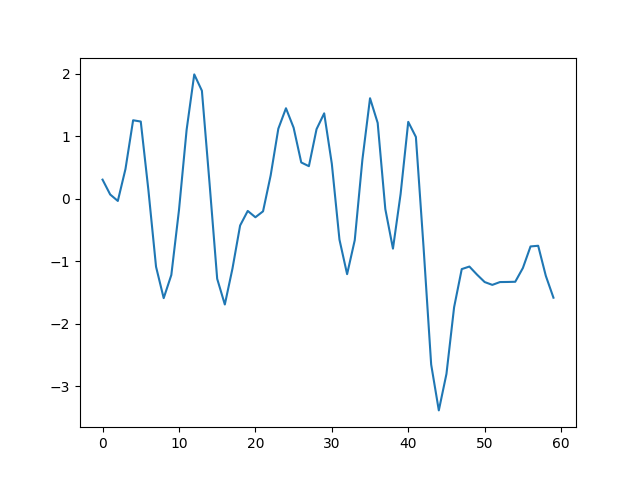

In [37]:
figure()
plot(numpyify(m))

In [ ]:
from trainingwheel.core import _callback_namespace

In [ ]:
_callback_namespace["phase_completed"].receivers.keys()

In [ ]:
@connect_via("phase_completed", loop.phases["train"]):
def log_metrics(phase, loop):
    assert phase.name == "train"
    metrics = loop.model.metrics
    
    epoch = 
    f""
    
    

In [ ]:
import tqdm

In [ ]:
var_model.metrics.keys()

In [ ]:
loop.callbacks["train.batch_size"].history

In [ ]:
test_params = dict(name="unnamed", parameter_name='batch_size', min_size=128, gamma=1.1)
dummy_loop = DummyLoop(name='TestLoop', state=State())
dummy_phase = DummyPhase(name='train')

A = ExpUpdater.simulate(100, init_kwargs=test_params, sender=dummy_phase, loop=dummy_loop)

plot(*np.array(A.history).T)

In [ ]:
var_model.cpu()

In [ ]:
m, v = var_model.predict(axfr)

In [ ]:
figure()
plot(numpyify(m), color='k')
plot(numpyify(F), color='r')

In [ ]:
figure()
plot(*np.array(loop.callbacks["metric_logger"].metric_log['validate.metrics.sigma2']).T)
twinx()
plot(*np.array(loop.callbacks["metric_logger"].metric_log['validate.metrics.Kr_lengthscale']).T)

In [ ]:
var_model.metrics